# 数据读取
读取csv数据，初次得到的数据结构如下：
```
data=
[
    {
        'date',
        'time',
        'data':[
            第road_id行，存放road_id的数据：[status,speed]
        ]
        不同时间的不同data不等长
    }
]
```

In [2]:
import csv
import os
file_path='data'
file_list=sorted(os.listdir(file_path))
date_time={}
for fname in file_list:
    if fname[0]=='.':
        continue
        
    date=fname[8:13]
    time=fname[14:22]
    
    if date>='10-02' and date<='10-10':
        if date not in date_time:
            date_time[date]=[time]
        else:
            date_time[date].append(time)
#把每一天的时间段数据归一化，抛弃尾端数据
min_time_num=216
for date,times in date_time.items():
    if len(times)<min_time_num:
        min_time_num=len(times)
for date in date_time:
    if len(date_time[date])>min_time_num:
        date_time[date]=date_time[date][0:min_time_num]

road_dict={}
data=[]

for date,times in date_time.items():
    for time in times:
        fname='ts_2021-'+date+' '+time+'.csv'
        date_data=[[0,0] for i in range(len(road_dict))]
        with open(file_path+'/'+fname,'r') as f:
            csv_reader = csv.reader(f)
            for row in csv_reader:
                if (row[0],row[2]) in road_dict:
                    date_data[road_dict[(row[0],row[2])]['id']][0]=int(row[1])
                    date_data[road_dict[(row[0],row[2])]['id']][1]=int(row[4])
                else:
                    road_dict[(row[0],row[2])]={'id':len(road_dict)}
                    date_data.append([int(row[1]),int(row[4])])
            f.close()
        #time=(int(fname[14:16])-5)*60+int(fname[17:19])
        data.append({'date':date,'time':time,'data':date_data})

查询道路的坐标

In [3]:
import requests
from fake_useragent import UserAgent
import json
import threading
import queue
import time
q = queue.Queue()
thread_list = []

def road_geomsg(road):
    road_location=(0.0,0.0)
    #爬取道路中心点
    server_host='https://restapi.amap.com/v3/geocode/geo'
    parameters={
        'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
        'city':'上海市',
        'address':road
    }
    response=requests.get(url=server_host,
                         headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                         params=parameters)
    response.encoding=response.apparent_encoding
    res=json.loads(response.text)
    if len(res['geocodes'])>0:
        location=res['geocodes'][0]['location'].split(',')
        road_location=(float(location[0]),float(location[1]))
        
    #爬取道路polyline
    server_host='https://restapi.amap.com/v3/traffic/status/road'
    parameters={
        'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
        'city':'上海市',
        'name':road,
        'level':5,
        'extensions':'all'
    }
    response=requests.get(url=server_host,
                         headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                         params=parameters)
    response.encoding=response.apparent_encoding
    res=json.loads(response.text)
    if 'trafficinfo' in res and 'roads' in res['trafficinfo']:
        for road_msg in res['trafficinfo']['roads']:
            if 'polyline' in road_msg:
                polyline=road_msg['polyline'].split(';')
                polyline=[(float(loc.split(',')[0]),float(loc.split(',')[1])) for loc in polyline]
                q.put({'road':road,'direction':road_msg['direction'],'location':road_location,'polyline':polyline})
    else:
        print(res)
            
road_names=[]
for road in road_dict:
    if road[0] not in road_names:
        road_names.append(road[0])

for name in road_names:
    thread=threading.Thread(target=road_geomsg, args=(name,))
    thread_list.append(thread)
    thread.start()
    time.sleep(0.1)
    
for thread in thread_list:
    thread.join()
thread_list.clear()

while not q.empty():
    msg=q.get()
    if (msg['road'],msg['direction']) in road_dict:
        road_dict[(msg['road'],msg['direction'])]['location']=msg['location']
        road_dict[(msg['road'],msg['direction'])]['polyline']=msg['polyline']

沪闵路
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}


查询上海市行政区边界polyline

In [28]:
server_host='https://restapi.amap.com/v3/config/district'
parameters={
    'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
    'keywords':'上海市',
    'subdistrict':0,
    'extensions':'all'
}
response=requests.get(url=server_host,
                     headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                     params=parameters)
response.encoding=response.apparent_encoding
res=json.loads(response.text)
poly_lines=res['districts'][0]['polyline'].split('|')
poly_lines=[line.split(';') for line in poly_lines]
for i in range(len(poly_lines)):
    poly_lines[i]=np.array([point.split(',') for point in poly_lines[i]],dtype=float).T
sh_poly_lines=poly_lines

# 数据清洗
二次处理读到的csv数据，使其转化为光栅(Raster)数据
```
dataset=[
    for each day
    [
        for each roads
        [
            for each time
            [
                [status,speed]
            ]
        ]
    ]
]
```
记每天为一个样本组，天数=样本数=N，每个样本记录了E个道路信息，每个道路包含T个时间片的监测数据，每个数据有C个特征

In [4]:
import numpy as np
from collections import Counter
dataset=[]
raster=[[] for i in range(len(road_dict))]
for index,item in enumerate(data):
    for road in road_dict:
        road_id=road_dict[(road)]['id']
        if road_id<len(item['data']):
            raster[road_id].append(item['data'][road_id])
        else:
            raster[road_id].append([0,0])

    if index==len(data)-1 or item['date']!=data[index+1]['date']:
        dataset.append(raster)
        raster=[[] for i in range(len(road_dict))]

dataset=np.array(dataset)

将每一天的数据拼接
```
dataset=[
    for each roads
    [
        for all time
        [
            [status,speed]
        ]
    ]
]
```
样本记录了E个道路信息，每个道路包含N*T个时间片的监测数据，每个数据有C个特征

In [5]:
dataset=np.concatenate(dataset,axis=1)

将数据缺失率在5%以上或者查询不到地理坐标的路段剔除

In [17]:
road_zip=dict(zip(road_dict.keys(), dataset))

delete_roads=[]
for road,data in road_zip.items():
    null_cnt=0
    zero_cnt=Counter(data[:,0])[0]
    if zero_cnt>len(data)*0.05 or 'location' not in road_dict[road] or road_dict[road]['location']==(0.0,0.0):
        delete_roads.append(road)
for road in delete_roads:
    road_zip.pop(road)

绘制光栅图

In [18]:
#print(road_dict)
import cv2 as cv
sample=np.array(list(road_zip.values()))
print(sample.shape)
image=85*sample[:,:,0]

cv.imwrite("filename.png", image)

(1009, 1935, 2)


True

绘制道路地理信息

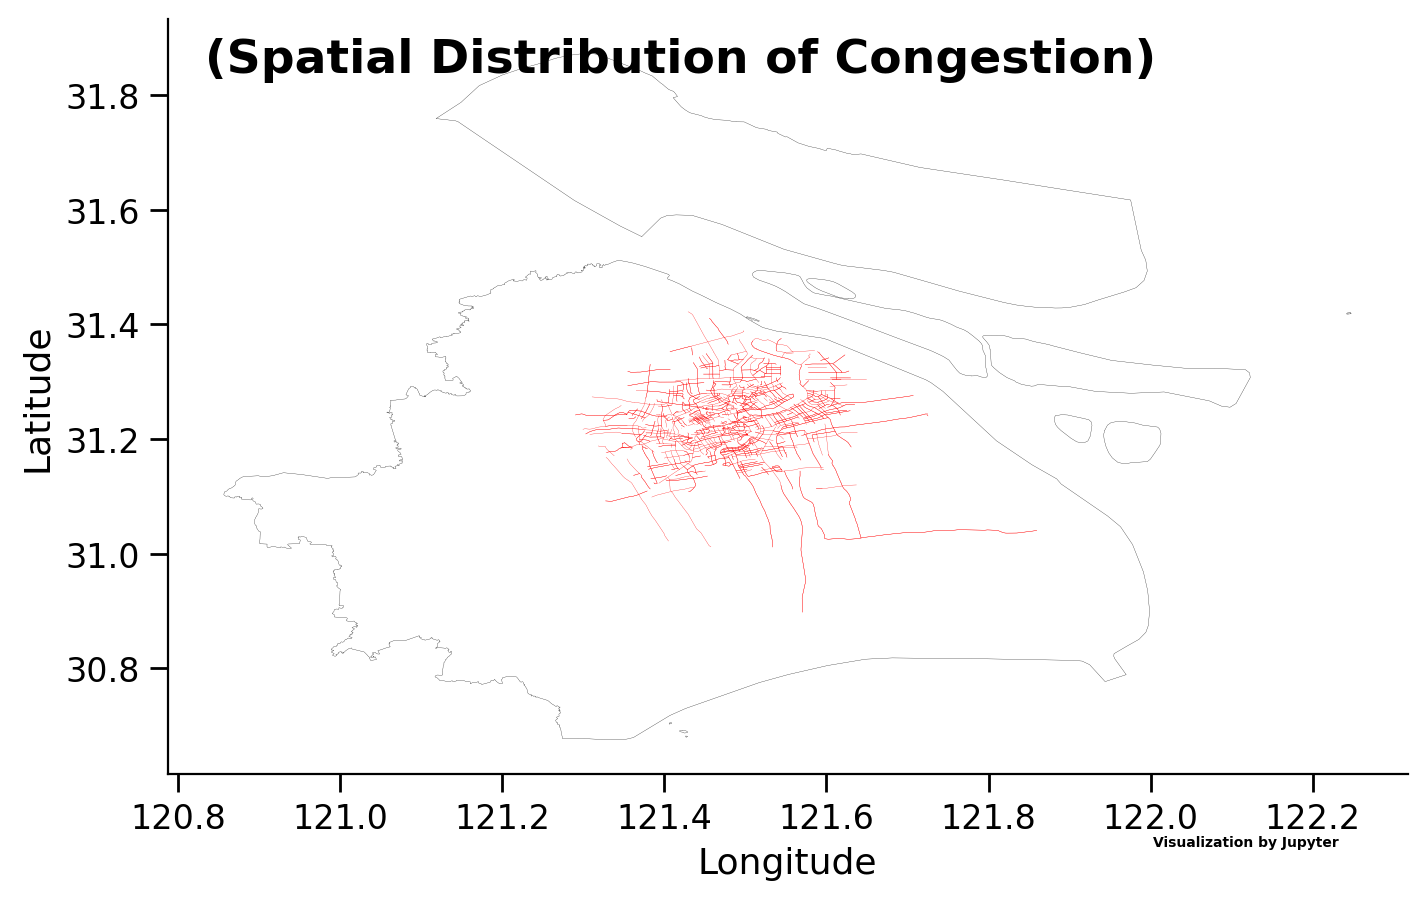

In [35]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
for line in sh_poly_lines:
    ax.plot(line[0],line[1],color='black',linewidth=.1)
for road in road_zip.keys():
    msg=road_dict[road]
    road_polyline=np.array(msg['polyline'])
    road_polyline=road_polyline.T
    ax.plot(road_polyline[0],road_polyline[1],color='r',linewidth=.1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Spatial Distribution of Congestion)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 模式挖掘统计
## 统计拥堵发生的时间特征

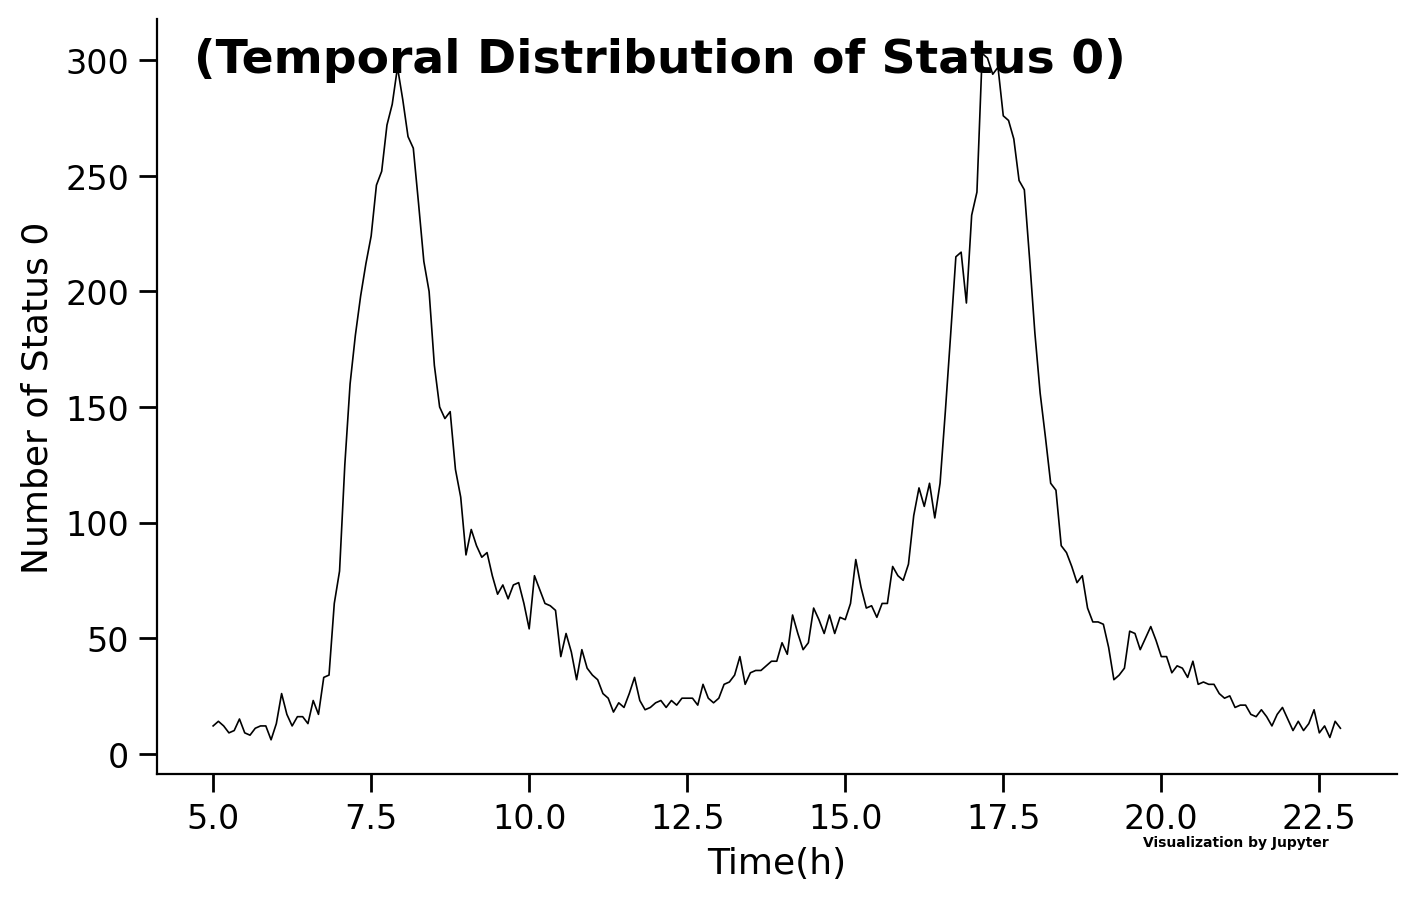

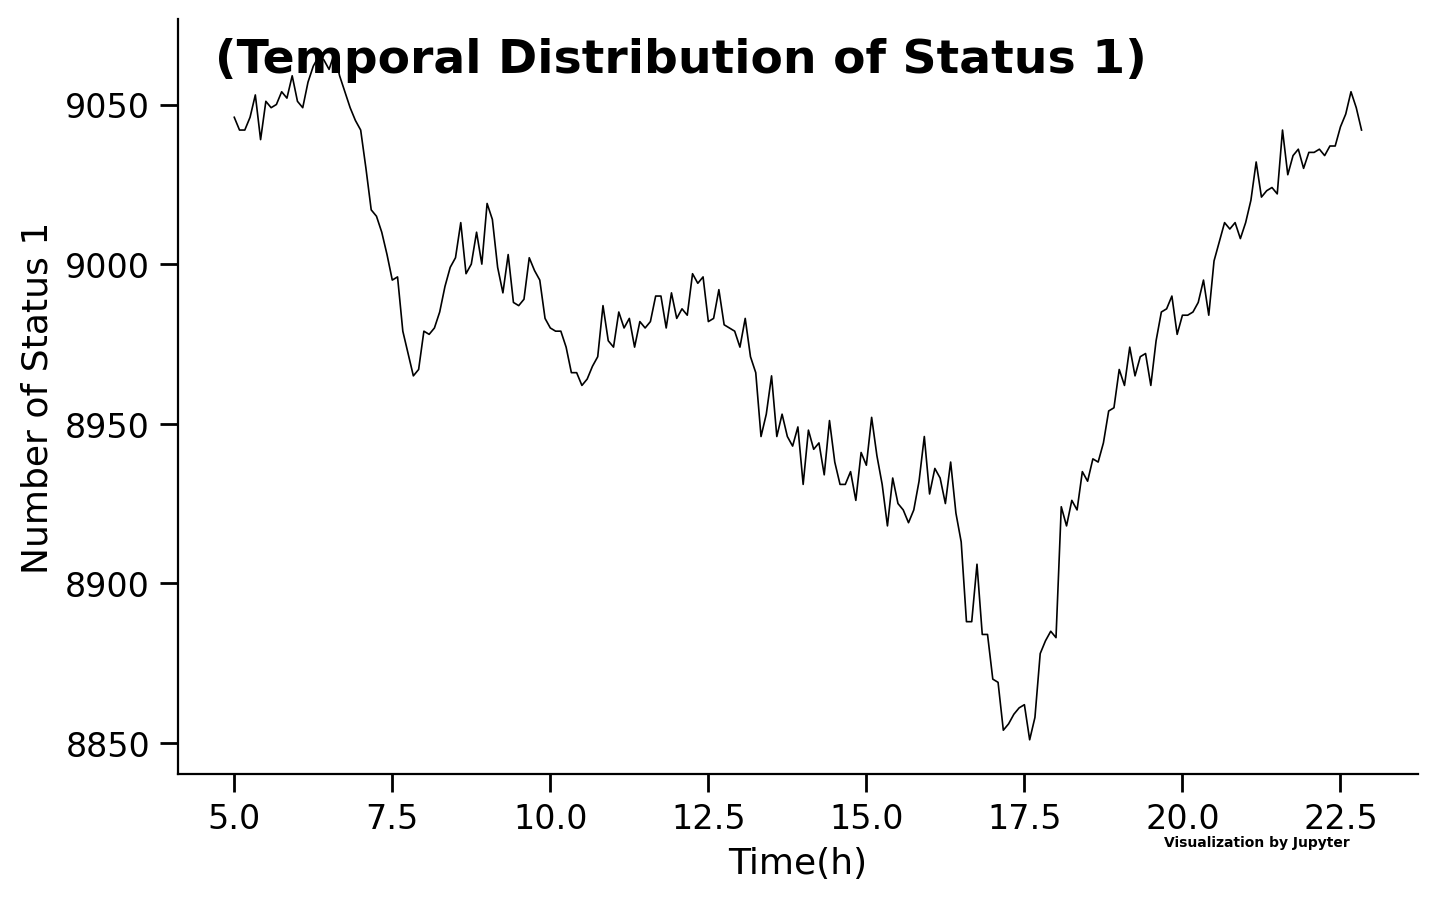

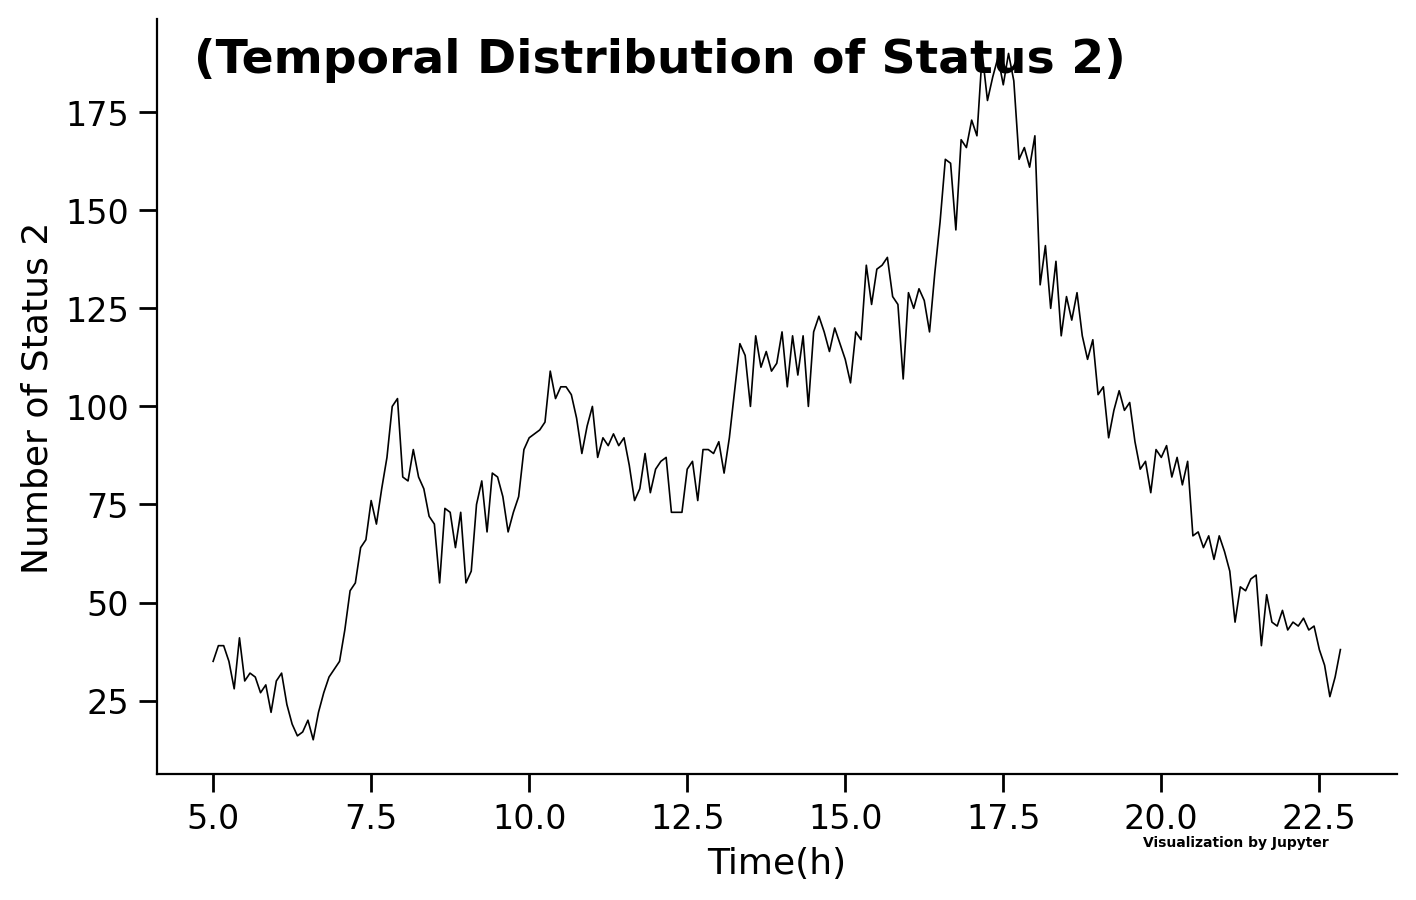

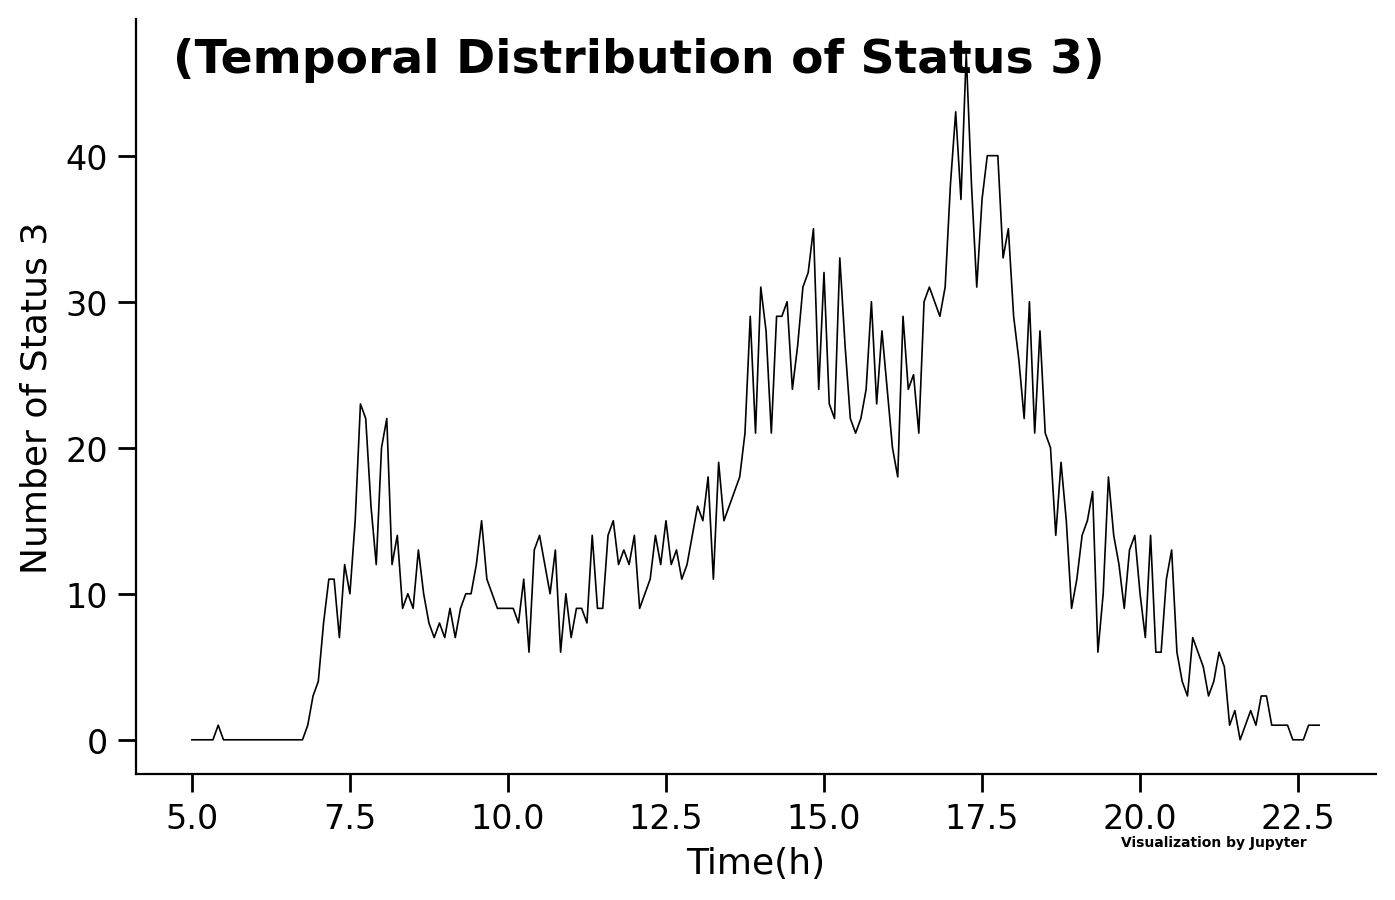

In [19]:
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[:,:,0]
data=data.reshape(-1,min_time_num)
data=data.T
result={0:[],1:[],2:[],3:[]}
for index,time_data in enumerate(data):
    cnt=Counter(time_data)
    for i in result:
        if i in cnt:
            result[i].append(cnt[i])
        else:
            result[i].append(0)
#把缺失值算作1（畅通）
result[1]=list(np.array(result[0])+np.array(result[1]))
label = [(i*5)/60+5 for i in range(len(result[0]))]
for index,value in result.items():
    fig,ax = plt.subplots(figsize=(8,5),dpi=200)
    ax.plot(label, value, color='black', linewidth=.6)
    ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'Number of Status {index}',fontsize=13)
    ax.set_xlabel('Time(h)',fontsize=13)
    text_font = {'size':'17','weight':'bold','color':'black'}
    ax.text(.03,.93,f'(Temporal Distribution of Status {index})',transform = ax.transAxes,fontdict=text_font,zorder=4)
    ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
    fig.show()


## 统计拥堵发生的持续时间特征


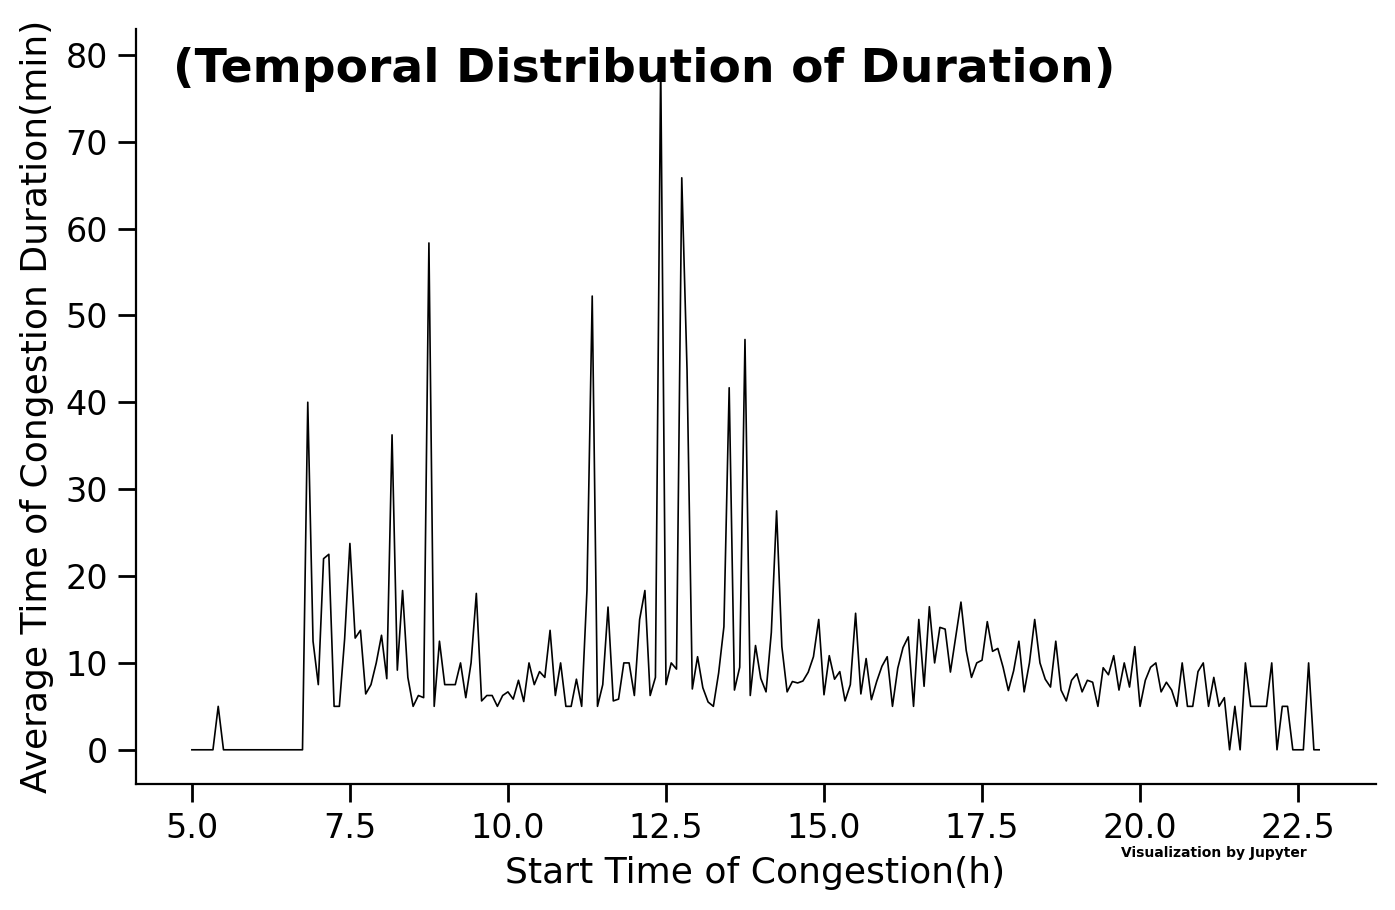

In [20]:
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[:,:,0]
data=data.reshape(data.shape[0],-1,min_time_num)

result=[]
for road in data:
    for date in road:
        start_time=0
        duration=0
        for index,item in enumerate(date):
            if start_time==0 and item>2:#统计拥堵等级为3的事件
                start_time=index
            if start_time!=0 and item<=2:
                duration=index-start_time
                #如果是range(1)则代表计算拥堵开始时刻的拥堵时间
                #如果是range(duration)则代表计算发生拥堵后每个时刻的拥堵时间
                for i in range(1):
                    result.append({'start_time':start_time+i,'duration':duration-i})
                start_time=0
                duration=0             
statistic={}
for item in result:
    if item['start_time'] in statistic:
        statistic[item['start_time']].append(item['duration'])
    else:
        statistic[item['start_time']]=[item['duration']]
avg_statistic=[]
for time_slice in range(min_time_num):
    if time_slice in statistic:
        avg_statistic.append(np.array(statistic[time_slice]).mean()*5)
    else:
        avg_statistic.append(0)

label = [(i*5)/60+5 for i in range(len(avg_statistic))]
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(label, avg_statistic, color='black', linewidth=.6)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Average Time of Congestion Duration(min)',fontsize=13)
ax.set_xlabel('Start Time of Congestion(h)',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Temporal Distribution of Duration)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

## 统计拥堵发生的空间特征

In [24]:
import math
import matplotlib.pyplot as plt
size=6#(size*5)^2 km^2
coord0=(121.475698,31.230428)
coord1=(coord0[0]-5*float(size/2)/(111.0*math.cos(coord0[1])),coord0[1]-5*float(size/2)/111.0)
coord2=(coord0[0]+5*float(size/2)/(111.0*math.cos(coord0[1])),coord0[1]+5*float(size/2)/111.0)
road_cgst_cnt={road:0 for road in road_zip.keys()}
for road,value in road_zip.items():
    for data in value:
        if data[0]>2:#统计拥堵等级为3的事件
            road_cgst_cnt[road]+=1
level=10#拥堵频率等级
min_cgst_cnt=min(road_cgst_cnt.values())
max_cgst_cnt=max(road_cgst_cnt.values())
unit=math.log(1+max_cgst_cnt-min_cgst_cnt)/level
road_cgst_statistic={i:[] for i in range(level+1)}
for road,cnt in road_cgst_cnt.items():
    lv=int(math.log(1+cnt-min_cgst_cnt)/unit)
    road_cgst_statistic[lv].append(list(road_dict[road]['location']))

3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
1
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
8
0
0
0
0
0
1
0
0
0
1
0
0
0
2
0
0
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0


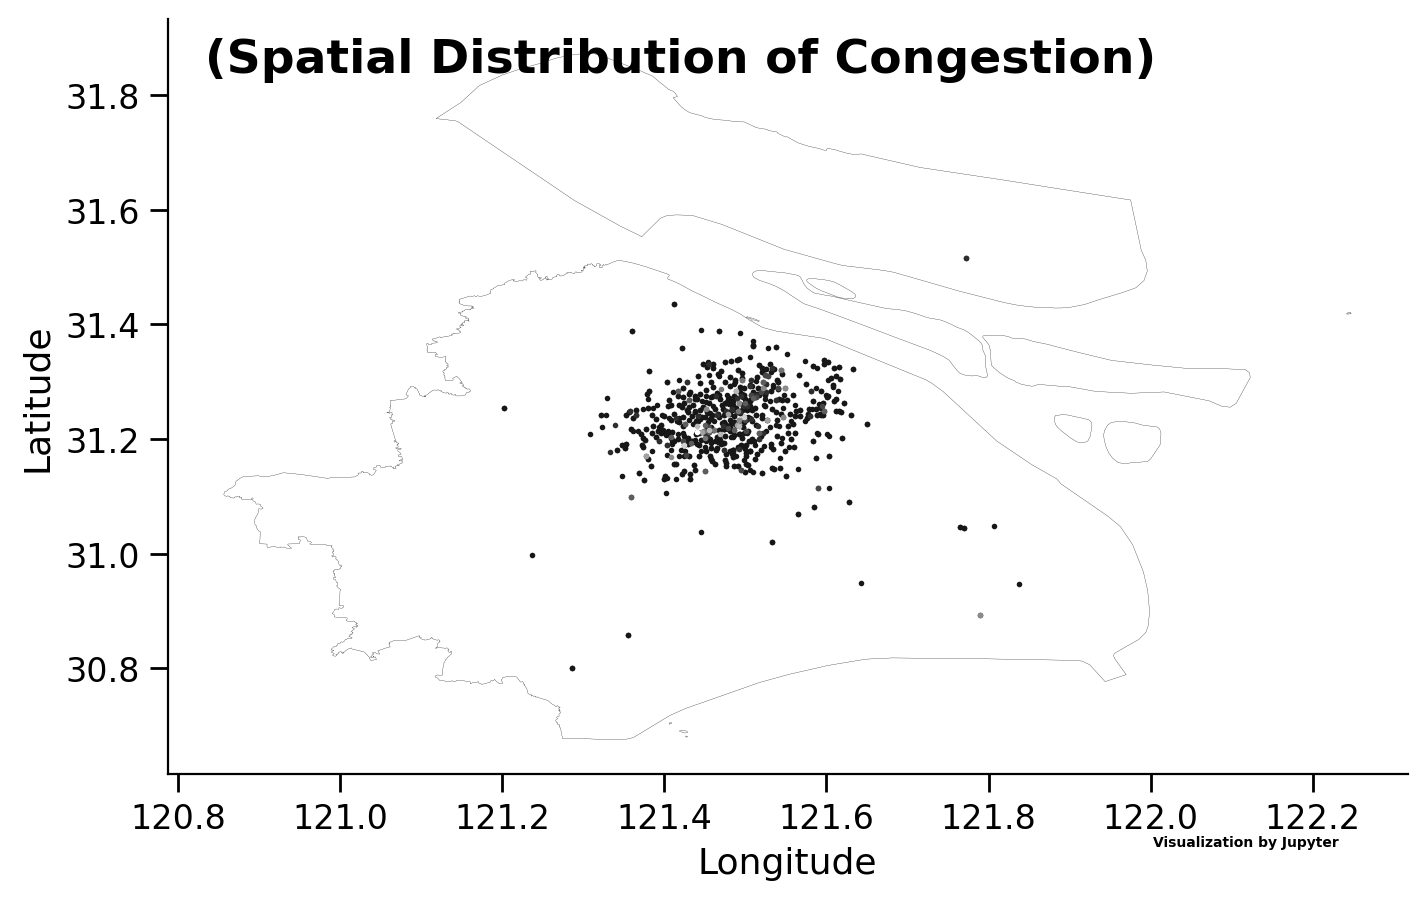

In [27]:
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
for line in sh_poly_lines:
    ax.plot(line[0],line[1],color='black',linewidth=.1)
for lv,points in road_cgst_statistic.items():
    if len(points)==0:
        continue
    np_points=np.array(points).T
    c=(lv+1)/(level+1)
    ax.scatter(np_points[0],np_points[1],color=(c,c,c),s=1)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Spatial Distribution of Congestion)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 聚类分析

In [ ]:
import random
def fast_DTW(s1, s2, T=5):
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(i-T-1,i+T+2):
            if j<0 or j>=len(s2):
                continue
            if math.fabs(i-j)<=T:
                dist= (s1[i]-s2[j])**2
                DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
            else:
                DTW[(i, j)]=float('inf')
    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1, s2, r=2):
    LB_sum = 0
    for ind, i in enumerate(s1):
         # print(s2)
        lower_bound = min(s2[(ind - r if ind - r >= 0 else 0):(ind + r)])
        upper_bound = max(s2[(ind - r if ind - r >= 0 else 0):(ind + r)])
        if i >= upper_bound:
            LB_sum = LB_sum + (i - upper_bound) ** 2
        elif i < lower_bound:
            LB_sum = LB_sum + (i - lower_bound) ** 2
    return math.sqrt(LB_sum)

def K_means(data,cluster_num,epoch,w=3):
    centroids={i:data[key] for i,key in enumerate(random.sample(list(data),cluster_num))}
    for n in range(epoch):
        clusters={}
        for key,value in data.items():
            min_dist=float('inf')
            closest_cluster=None
            for ckey,cvalue in centroids.items():
                cur_dist=fast_DTW(value,cvalue)
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_cluster=ckey
            if closest_cluster in clusters:
                clusters[closest_cluster].append(key)
            else:
                clusters[closest_cluster]=[key]
        for key,value in clusters.items():
            cluster_sum=0
            for item in value:
                cluster_sum+=data[item]
            centroids[key]=[m/len(clusters[key]) for m in cluster_sum]
    return centroids,clusters

data=np.array(list(road_zip.values()))[:,:,0]
assemble_matrix=[]
for s1 in data:
    assemble_matrix.append([])
    for s2 in data:
        assemble_matrix[-1].append(fast_DTW(s1,s2))
print(np.array(assemble_matrix))
            




# centroids,clusters=K_means(data,2,2)
# print(clusters)
# import time
 
# time_start = time.time() #开始计时
# print(fast_DTW(data[0],data[1]))
# time_end = time.time()    #结束计时
# time_c= time_end - time_start   #运行所花时间
# print('time cost', time_c, 's')

# time_start = time.time() #开始计时
# print(LB_Keogh(data[0],data[1]))
# time_end = time.time()    #结束计时
# time_c= time_end - time_start   #运行所花时间
# print('time cost', time_c, 's')

# for i in range(100):
#     for j in range(i,100):
#         fdtw=fast_DTW(data[i],data[j])
#         lb=LB_Keogh(data[i],data[j])
#         if fdtw==0 or (fdtw-lb)/fdtw<0.1:
#             print('ok')
#         else:
#             print('err')


In [26]:
import requests
from fake_useragent import UserAgent
import json
server_host='https://restapi.amap.com/v3/config/district'
parameters={
    'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
    'keywords':'上海市',
    'subdistrict':0,
    'extensions':'all'
}
response=requests.get(url=server_host,
                     headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                     params=parameters)
response.encoding=response.apparent_encoding
res=json.loads(response.text)
poly_lines=res['districts'][0]['polyline'].split('|')
poly_lines=[line.split(';') for line in poly_lines]
for i in range(len(poly_lines)):
    poly_lines[i]=np.array([point.split(',') for point in poly_lines[i]],dtype=float).T
sh_poly_lines=poly_lines

获取上海市的轮廓坐标